## Data Wrangling and Cleaning

In [1]:
# import the libraries
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import json

# convert scientific notation to decimals
pd.set_option('display.float_format', lambda x: '%.2f' % x)

### Load data
First I load the relevant data files (museum data source: https://www.kaggle.com/annecool37/museum-data), which are separated into several sets and split between US and world data. For this analysis, I have not considered the additional data files containing review content, and review quotes due to the need for NLP, considering the richness of the data even excluding these fields.

I also am using an external dataset containing a list of countries with corresponding regions/continents to enable regional data analysis (source: https://unstats.un.org/unsd/methodology/m49/overview/)

In [2]:
# load data

# museum info
df_museum_US = pd.read_csv('data/tripadvisor_museum_USonly.csv')
df_museum_world = pd.read_csv('data/tripadvisor_museum_world.csv')

# ratings
df_ratings_US = pd.read_json('data/traveler_rating_USonly.json')
df_ratings_world = pd.read_json('data/traveler_rating_world.json')

# traveler types
df_travelers_US = pd.read_json('data/traveler_type_USonly.json')
df_travelers_world = pd.read_json('data/traveler_type_world.json')

# museum categories - using json library to load as dict because pd.read_json throws error
# due to data of variable length (inconsistent # category types per museum)
with open('data/museum_categories_USonly.json') as json_data_US:
    json_category_US = json.load(json_data_US)
    
with open('data/museum_categories_world.json') as json_data_world:
    json_category_world = json.load(json_data_world)
    
# tag clouds - also loading as dict for same reason as museum categories
with open('data/tag_clouds_USonly.json') as json_data_US:
    json_tags_US = json.load(json_data_US)
    
with open('data/tag_clouds_world.json') as json_data_world:
    json_tags_world = json.load(json_data_world)

# list of countries and world regions/continents
df_world_regions = pd.read_csv('data/UNSD — Methodology.csv')

### Inspect and  clean data
I next inspect and clean the data per set (I will only combine US and world data per set at this stage - I will create a final merged set at the end). The json file column names are provided with data description on kaggle, and the US and world sets of each set should be the same format.

#### Museum info data:

In [3]:
# inspect museum info data
print('US museum info')
print(df_museum_US.columns)
print(df_museum_US.describe())
print(df_museum_US.info())
print(df_museum_US.head())
print('')
print('World museum info')
print(df_museum_world.columns)
print(df_museum_world.describe())
print(df_museum_world.info())
print(df_museum_world.head())


US museum info
Index(['Unnamed: 0', 'Address', 'Description', 'FeatureCount', 'Fee',
       'Langtitude', 'Latitude', 'LengthOfVisit', 'MuseumName', 'PhoneNum',
       'Rank', 'Rating', 'ReviewCount', 'TotalThingsToDo'],
      dtype='object')
       Unnamed: 0  FeatureCount  Langtitude  Latitude    Rank  Rating
count     1014.00       1014.00     1008.00   1008.00 1014.00 1014.00
mean       506.50          0.66      -92.45     37.17   15.19    4.45
std        292.86          1.66       17.18      5.80   28.24    0.30
min          0.00          0.00     -159.72     19.30    1.00    2.50
25%        253.25          0.00     -104.95     33.46    2.00    4.50
50%        506.50          0.00      -87.59     37.76    6.00    4.50
75%        759.75          0.00      -79.69     40.88   17.00    4.50
max       1013.00         12.00      -68.20     64.86  397.00    5.00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 14 columns):
Unnamed: 0         1

From these summaries, I observe the following:

1. The formats of both files were identical, so the data can be concatenated.
2. The first column appears to be the index, and can be dropped (I won't bother to reload the file with this as the index because it is just a basic numeric index)
3. Longitude column has been misspelled and should be updated.
4. There appear to be US entries in the world data set. This may indicate duplicate data.
5. The rank, feature count and rating have been correctly interpreted as numeric, but the review count and total things to do have not, so they must be fixed.
6. There appear to be missing values in the description, fee, latitude, longitude, length of visit columns, and phone number columns for both sets of data, which will need to be evaluated further.
7. I would like to use city, country and state information for my analysis, but there are no separate columns these fields, so I will try to parse these from the address to enable some diagnostic evaluation by location.

In [4]:
# concatenate US and world dataframes
df_museum = pd.concat([df_museum_US, df_museum_world]).reset_index()
df_museum.tail()

,index,Unnamed: 0,Address,Description,FeatureCount,Fee,Langtitude,Latitude,LengthOfVisit,MuseumName,PhoneNum,Rank,Rating,ReviewCount,TotalThingsToDo
2021,1007,1007,"1 Bowling Grn, New York City, NY 10004-1415",The New York branch of the Smithsonian Institu...,1,No,-74.01,40.70,1-2 hours,National Museum of the American Indian,212-514-3700,91,4.00,474,"1,028"
2022,1008,1008,"Via Marconi, 1, 20122 Milan, Italy","The Museo del Novecento, located inside the Pa...",1,NaN,9.19,45.46,1-2 hours,Museo del Novecento,+39 0288444061,28,4.50,"1,197",622
2023,1009,1009,"10 Childrens Way, Pittsburgh, PA 15212-5250",Hi! We're having a great time at Children's Mu...,3,NaN,-80.01,40.45,More than 3 hours,Children's Museum of Pittsburgh,+1 412-322-5058,20,4.50,414,150
2024,1010,1010,"15 25a Buitenkant Street, Cape Town Central 80...",The apartheid nationalist government destroyed...,1,NaN,18.42,-33.93,NaN,District Six Museum,+27 21 466 7200,20,4.50,"1,083",218
2025,1011,1011,"64 King Edward Parade, Devonport 0624, New Zea...",NaN,0,NaN,174.81,-36.83,NaN,Torpedo Bay Navy Museum,+64 9-445 5186,2,4.50,143,11


In [5]:
# drop index and Unnamed: 0 columns and rename 'Langtitude' column to Longitude
df_museum.drop(['index','Unnamed: 0'], axis=1, inplace=True)
df_museum.rename(columns={'Langtitude':'Longitude'}, inplace=True)
df_museum.head()

,Address,Description,FeatureCount,Fee,Longitude,Latitude,LengthOfVisit,MuseumName,PhoneNum,Rank,Rating,ReviewCount,TotalThingsToDo
0,"555 Pennsylvania Ave NW, Washington DC, DC 200...",Find out for yourself why everyone is calling ...,3,Yes,-77.02,38.89,2-3 hours,Newseum,+1 888-639-7386,8,4.50,"6,309",398
1,"1000 5th Ave, New York City, NY 10028-0198",At New York City's most visited museum and att...,12,Yes,-73.96,40.78,2-3 hours,The Metropolitan Museum of Art,1 212-535-7710,2,5.00,"36,627","1,028"
2,"945 Magazine Street, New Orleans, LA 70130-3813","Founded by historian and author, Stephen Ambro...",11,NaN,-90.07,29.94,NaN,The National WWII Museum,+1 504-528-1944,1,5.00,"15,611",319
3,"2001 N Colorado Blvd, Denver, CO 80205-5798",The Denver Museum of Nature & Science is the R...,0,NaN,-104.94,39.77,NaN,Denver Museum of Nature & Science,303-370-6000,4,4.50,"2,564",231
4,"111 S Michigan Ave, Chicago, IL 60603-6488","This Classical Renaissance structure, guarded ...",5,Yes,-87.62,41.88,More than 3 hours,Art Institute of Chicago,312 443 3600,1,5.00,"15,532",614


In [6]:
# check for duplicate museum entries
print(df_museum.info())
print(df_museum[df_museum.duplicated()])

# drop duplicate entries
df_museum.drop_duplicates(keep='first', inplace=True)
print(df_museum.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2026 entries, 0 to 2025
Data columns (total 13 columns):
Address            2026 non-null object
Description        1542 non-null object
FeatureCount       2026 non-null int64
Fee                390 non-null object
Longitude          1980 non-null float64
Latitude           1980 non-null float64
LengthOfVisit      799 non-null object
MuseumName         2026 non-null object
PhoneNum           2017 non-null object
Rank               2026 non-null int64
Rating             2026 non-null float64
ReviewCount        2026 non-null object
TotalThingsToDo    2026 non-null object
dtypes: float64(3), int64(2), object(8)
memory usage: 205.8+ KB
None
                                                Address  \
1014  555 Pennsylvania Ave NW, Washington DC, DC 200...   
1026        2001 N Colorado Blvd, Denver, CO 80205-5798   
1027         111 S Michigan Ave, Chicago, IL 60603-6488   
1033  465 Huntington Ave, Avenue of the Arts, Boston...   
1035      

Removing duplicate entries took the total count from 2026 to 1662.

In [7]:
# convert data type of ReviewCount and TotalThingsToDo
df_museum['ReviewCount'] = df_museum['ReviewCount'].str.replace(',','').astype(int)
df_museum['TotalThingsToDo'] = df_museum['TotalThingsToDo'].str.replace(',','').astype(int)
df_museum.info()
df_museum.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1662 entries, 0 to 2025
Data columns (total 13 columns):
Address            1662 non-null object
Description        1217 non-null object
FeatureCount       1662 non-null int64
Fee                260 non-null object
Longitude          1618 non-null float64
Latitude           1618 non-null float64
LengthOfVisit      607 non-null object
MuseumName         1662 non-null object
PhoneNum           1655 non-null object
Rank               1662 non-null int64
Rating             1662 non-null float64
ReviewCount        1662 non-null int32
TotalThingsToDo    1662 non-null int32
dtypes: float64(3), int32(2), int64(2), object(6)
memory usage: 168.8+ KB


,Address,Description,FeatureCount,Fee,Longitude,Latitude,LengthOfVisit,MuseumName,PhoneNum,Rank,Rating,ReviewCount,TotalThingsToDo
0,"555 Pennsylvania Ave NW, Washington DC, DC 200...",Find out for yourself why everyone is calling ...,3,Yes,-77.02,38.89,2-3 hours,Newseum,+1 888-639-7386,8,4.50,6309,398
1,"1000 5th Ave, New York City, NY 10028-0198",At New York City's most visited museum and att...,12,Yes,-73.96,40.78,2-3 hours,The Metropolitan Museum of Art,1 212-535-7710,2,5.00,36627,1028
2,"945 Magazine Street, New Orleans, LA 70130-3813","Founded by historian and author, Stephen Ambro...",11,NaN,-90.07,29.94,NaN,The National WWII Museum,+1 504-528-1944,1,5.00,15611,319
3,"2001 N Colorado Blvd, Denver, CO 80205-5798",The Denver Museum of Nature & Science is the R...,0,NaN,-104.94,39.77,NaN,Denver Museum of Nature & Science,303-370-6000,4,4.50,2564,231
4,"111 S Michigan Ave, Chicago, IL 60603-6488","This Classical Renaissance structure, guarded ...",5,Yes,-87.62,41.88,More than 3 hours,Art Institute of Chicago,312 443 3600,1,5.00,15532,614


In [8]:
# number of missing values by columns
print(df_museum.isnull().sum())

Address               0
Description         445
FeatureCount          0
Fee                1402
Longitude            44
Latitude             44
LengthOfVisit      1055
MuseumName            0
PhoneNum              7
Rank                  0
Rating                0
ReviewCount           0
TotalThingsToDo       0
dtype: int64


Based on the number of missing values for Description, Fee and Length of Visit compared to the total number of entries (1662), and the fact that there is no reasonable way to interpolate this data, I will have to remove these columns from my analysis.

For the latitude and longitude, I could implement a geocoding service to populate missing values based on the address, but I am not going to do this for the sake of time,  and the fact that I won't use these columns in my analysis.

For the phone number, there is no way to interpolate the data even though there are very few missing entries, but I will also not be using this field.

In [9]:
# create country columns from address

# create string pattern to identify where an address is in the US - based on containing a 2 letter state abbreviation following a comma
state_pattern = ', [A-Z]{2}'

# create a Country column that assigns USA as the country when the Address contains a state abbreviation
# otherwise split the address based on a comma delimiter, and assign the country as the last element in this list, and strip whitespace
df_museum['Country'] = np.where((df_museum['Address'].str.contains(state_pattern)),'USA', df_museum['Address'].str.split(',').str[-1].str.strip())
df_museum.head()

,Address,Description,FeatureCount,Fee,Longitude,Latitude,LengthOfVisit,MuseumName,PhoneNum,Rank,Rating,ReviewCount,TotalThingsToDo,Country
0,"555 Pennsylvania Ave NW, Washington DC, DC 200...",Find out for yourself why everyone is calling ...,3,Yes,-77.02,38.89,2-3 hours,Newseum,+1 888-639-7386,8,4.50,6309,398,USA
1,"1000 5th Ave, New York City, NY 10028-0198",At New York City's most visited museum and att...,12,Yes,-73.96,40.78,2-3 hours,The Metropolitan Museum of Art,1 212-535-7710,2,5.00,36627,1028,USA
2,"945 Magazine Street, New Orleans, LA 70130-3813","Founded by historian and author, Stephen Ambro...",11,NaN,-90.07,29.94,NaN,The National WWII Museum,+1 504-528-1944,1,5.00,15611,319,USA
3,"2001 N Colorado Blvd, Denver, CO 80205-5798",The Denver Museum of Nature & Science is the R...,0,NaN,-104.94,39.77,NaN,Denver Museum of Nature & Science,303-370-6000,4,4.50,2564,231,USA
4,"111 S Michigan Ave, Chicago, IL 60603-6488","This Classical Renaissance structure, guarded ...",5,Yes,-87.62,41.88,More than 3 hours,Art Institute of Chicago,312 443 3600,1,5.00,15532,614,USA


In [10]:
# check validity of Country column
print(df_museum['Country'].unique())

['USA' 'England' 'The Netherlands' 'France' 'Germany' 'Sweden' 'Greece'
 'Spain' 'Norway' 'Austria' 'Scotland' 'Denmark' 'Italy'
 'Tokyo Prefecture' 'Mexico' 'Canada' 'Vietnam' 'Turkey' 'Peru' 'Russia'
 'China' 'South Korea' 'Colombia' 'Czech Republic' 'Indonesia' 'Poland'
 'Hungary' 'Estonia' 'Australia' 'Ireland' 'Hiroshima Prefecture'
 'Malaysia' 'Osaka Prefecture' 'United Arab Emirates' 'Portugal' 'Israel'
 'Iceland' 'Argentina' 'Monaco' 'Singapore' 'Wales' 'India' 'Qatar'
 'New Zealand' 'The Netherlands (Formerly Netherlands Maritime Museum)'
 'Chile' 'Romania' 'Croatia' 'Philippines' 'Belgium' 'South Africa'
 'Egypt' 'Cambodia' 'Shiga Prefecture' 'Brazil' 'Switzerland'
 'Aichi Prefecture' 'Thailand' 'Fukui Prefecture' 'Ishikawa Prefecture'
 'Finland' 'The Netherlands (Formerly Museum Het Prinsenhof)' 'Bulgaria'
 'Lithuania' 'Costa Rica (Formerly Gold Museum (Museo del Oro))' 'Serbia'
 'Northern Ireland' 'Slovakia' 'Latvia' 'Morocco' 'Shimane Prefecture'
 'Nagasaki Prefecture' 'Ne

In [11]:
# correct countries containing brackets
df_museum['Country'] = df_museum['Country'].str.split(" \(").str[0]
print(df_museum['Country'].unique())

['USA' 'England' 'The Netherlands' 'France' 'Germany' 'Sweden' 'Greece'
 'Spain' 'Norway' 'Austria' 'Scotland' 'Denmark' 'Italy'
 'Tokyo Prefecture' 'Mexico' 'Canada' 'Vietnam' 'Turkey' 'Peru' 'Russia'
 'China' 'South Korea' 'Colombia' 'Czech Republic' 'Indonesia' 'Poland'
 'Hungary' 'Estonia' 'Australia' 'Ireland' 'Hiroshima Prefecture'
 'Malaysia' 'Osaka Prefecture' 'United Arab Emirates' 'Portugal' 'Israel'
 'Iceland' 'Argentina' 'Monaco' 'Singapore' 'Wales' 'India' 'Qatar'
 'New Zealand' 'Chile' 'Romania' 'Croatia' 'Philippines' 'Belgium'
 'South Africa' 'Egypt' 'Cambodia' 'Shiga Prefecture' 'Brazil'
 'Switzerland' 'Aichi Prefecture' 'Thailand' 'Fukui Prefecture'
 'Ishikawa Prefecture' 'Finland' 'Bulgaria' 'Lithuania' 'Costa Rica'
 'Serbia' 'Northern Ireland' 'Slovakia' 'Latvia' 'Morocco'
 'Shimane Prefecture' 'Nagasaki Prefecture' 'New Providence Island'
 'Kanagawa Prefecture' 'Taiwan' 'Bahrain' 'Saudi Arabia'
 'Saitama Prefecture' 'Ukraine' 'Curacao' 'Malta' 'Cuba' 'Hokkaido'
 'E

In [12]:
# convert entries containing 'Prefecture', and the entry Hokkaido to Japan
df_museum['Country'][(df_museum['Country'].str.contains('Prefecture')) | (df_museum['Country'] == 'Hokkaido')] = 'Japan'
print(df_museum['Country'].unique())

['USA' 'England' 'The Netherlands' 'France' 'Germany' 'Sweden' 'Greece'
 'Spain' 'Norway' 'Austria' 'Scotland' 'Denmark' 'Italy' 'Japan' 'Mexico'
 'Canada' 'Vietnam' 'Turkey' 'Peru' 'Russia' 'China' 'South Korea'
 'Colombia' 'Czech Republic' 'Indonesia' 'Poland' 'Hungary' 'Estonia'
 'Australia' 'Ireland' 'Malaysia' 'United Arab Emirates' 'Portugal'
 'Israel' 'Iceland' 'Argentina' 'Monaco' 'Singapore' 'Wales' 'India'
 'Qatar' 'New Zealand' 'Chile' 'Romania' 'Croatia' 'Philippines' 'Belgium'
 'South Africa' 'Egypt' 'Cambodia' 'Brazil' 'Switzerland' 'Thailand'
 'Finland' 'Bulgaria' 'Lithuania' 'Costa Rica' 'Serbia' 'Northern Ireland'
 'Slovakia' 'Latvia' 'Morocco' 'New Providence Island' 'Taiwan' 'Bahrain'
 'Saudi Arabia' 'Ukraine' 'Curacao' 'Malta' 'Cuba' 'Ecuador' 'Uruguay'
 'Georgia' 'Kenya' 'Panama' 'Jamaica' 'Terra Cotta Warriors and Horses)'
 'Oman']


C:\Users\Kirsten\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


I'm not sure why I'm getting this warning, because the command appears to have executed correctly. Any feedback would be appreciated.

In [13]:
# find address of incorrect entry "Terra Cotta Warriors and Horses)"
df_museum['Address'][df_museum['Country']=='Terra Cotta Warriors and Horses)']

1977    Qinling North Road, Lintong District, Xi'an 71...
Name: Address, dtype: object

In [14]:
# correct final countries
df_museum['Country'][df_museum['Country']=='Terra Cotta Warriors and Horses)'] = 'China'
df_museum['Country'][df_museum['Country']=='New Providence Island'] = 'The Bahamas'
print(df_museum['Country'].unique())

['USA' 'England' 'The Netherlands' 'France' 'Germany' 'Sweden' 'Greece'
 'Spain' 'Norway' 'Austria' 'Scotland' 'Denmark' 'Italy' 'Japan' 'Mexico'
 'Canada' 'Vietnam' 'Turkey' 'Peru' 'Russia' 'China' 'South Korea'
 'Colombia' 'Czech Republic' 'Indonesia' 'Poland' 'Hungary' 'Estonia'
 'Australia' 'Ireland' 'Malaysia' 'United Arab Emirates' 'Portugal'
 'Israel' 'Iceland' 'Argentina' 'Monaco' 'Singapore' 'Wales' 'India'
 'Qatar' 'New Zealand' 'Chile' 'Romania' 'Croatia' 'Philippines' 'Belgium'
 'South Africa' 'Egypt' 'Cambodia' 'Brazil' 'Switzerland' 'Thailand'
 'Finland' 'Bulgaria' 'Lithuania' 'Costa Rica' 'Serbia' 'Northern Ireland'
 'Slovakia' 'Latvia' 'Morocco' 'The Bahamas' 'Taiwan' 'Bahrain'
 'Saudi Arabia' 'Ukraine' 'Curacao' 'Malta' 'Cuba' 'Ecuador' 'Uruguay'
 'Georgia' 'Kenya' 'Panama' 'Jamaica' 'Oman']


C:\Users\Kirsten\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Kirsten\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
# create continent/region columns based on country
df_world_regions.head()

,Global Code,Global Name,Region Code,Region Name,Sub-region Code,Sub-region Name,Intermediate Region Code,Intermediate Region Name,Country or Area,M49 Code,ISO-alpha3 Code,Least Developed Countries (LDC),Land Locked Developing Countries (LLDC),Small Island Developing States (SIDS),Developed / Developing Countries
0,1,World,2.00,Africa,15.00,Northern Africa,nan,NaN,Algeria,12,DZA,NaN,NaN,NaN,Developing
1,1,World,2.00,Africa,15.00,Northern Africa,nan,NaN,Egypt,818,EGY,NaN,NaN,NaN,Developing
2,1,World,2.00,Africa,15.00,Northern Africa,nan,NaN,Libya,434,LBY,NaN,NaN,NaN,Developing
3,1,World,2.00,Africa,15.00,Northern Africa,nan,NaN,Morocco,504,MAR,NaN,NaN,NaN,Developing
4,1,World,2.00,Africa,15.00,Northern Africa,nan,NaN,Sudan,729,SDN,x,NaN,NaN,Developing


In [16]:
# subset world region data for columns of interest
df_continents = df_world_regions[['Region Name','Sub-region Name','Country or Area']]
df_continents.columns = ['Continent','SubRegion','Country']
df_continents.head()

,Continent,SubRegion,Country
0,Africa,Northern Africa,Algeria
1,Africa,Northern Africa,Egypt
2,Africa,Northern Africa,Libya
3,Africa,Northern Africa,Morocco
4,Africa,Northern Africa,Sudan


In [17]:
# merge continent data into museum data by country
df_museum = df_museum.merge(df_continents, on='Country', how='left')

In [18]:
# check if any errors
df_museum['Country'][df_museum['Continent'].isnull()].unique()

array(['USA', 'England', 'The Netherlands', 'Scotland', 'Vietnam',
       'Russia', 'South Korea', 'Czech Republic', 'Wales',
       'Northern Ireland', 'The Bahamas', 'Taiwan', 'Curacao'],
      dtype=object)

In [19]:
# fix countries with errors

# US
df_museum['Continent'][df_museum['Country']=='USA'] = 'Americas'
df_museum['SubRegion'][df_museum['Country']=='USA'] = 'Northern America'
# Bahamas and Curacao
df_museum['Continent'][(df_museum['Country']=='The Bahamas') | (df_museum['Country']=='Curacao')] = 'Americas'
df_museum['SubRegion'][(df_museum['Country']=='The Bahamas') | (df_museum['Country']=='Curacao')] = 'Latin America and the Caribbean'
# UK
df_museum['Continent'][(df_museum['Country']=='England') | (df_museum['Country']=='Scotland') | (df_museum['Country']=='Wales') | (df_museum['Country']=='Northern Ireland')] = 'Europe'
df_museum['SubRegion'][(df_museum['Country']=='England') | (df_museum['Country']=='Scotland') | (df_museum['Country']=='Wales') | (df_museum['Country']=='Northern Ireland')] = 'Northern Europe'
# Netherlands
df_museum['Continent'][df_museum['Country']=='The Netherlands'] = 'Europe'
df_museum['SubRegion'][df_museum['Country']=='The Netherlands'] = 'Western Europe'
# Czech Republic and Russia
df_museum['Continent'][(df_museum['Country']=='Czech Republic') | (df_museum['Country']=='Russia')] = 'Europe'
df_museum['SubRegion'][(df_museum['Country']=='Czech Republic') | (df_museum['Country']=='Russia')] = 'Eastern Europe'
# Vietnam
df_museum['Continent'][df_museum['Country']=='Vietnam'] = 'Asia'
df_museum['SubRegion'][df_museum['Country']=='Vietnam'] = 'South-eastern Asia'
# Taiwan and South Korea
df_museum['Continent'][(df_museum['Country']=='Taiwan') | (df_museum['Country']=='South Korea')] = 'Asia'
df_museum['SubRegion'][(df_museum['Country']=='Taiwan') | (df_museum['Country']=='South Korea')] = 'Eastern Asia'
df_museum.info()

C:\Users\Kirsten\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Kirsten\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Kirsten\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\Kirsten\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarn

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1662 entries, 0 to 1661
Data columns (total 16 columns):
Address            1662 non-null object
Description        1217 non-null object
FeatureCount       1662 non-null int64
Fee                260 non-null object
Longitude          1618 non-null float64
Latitude           1618 non-null float64
LengthOfVisit      607 non-null object
MuseumName         1662 non-null object
PhoneNum           1655 non-null object
Rank               1662 non-null int64
Rating             1662 non-null float64
ReviewCount        1662 non-null int32
TotalThingsToDo    1662 non-null int32
Country            1662 non-null object
Continent          1662 non-null object
SubRegion          1662 non-null object
dtypes: float64(3), int32(2), int64(2), object(9)
memory usage: 207.8+ KB


C:\Users\Kirsten\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Kirsten\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [20]:
# create US city and state columns
# for all entries in the USA, parse the city and state from the address
# possible for US based on regularity in address, but variability in world addresses make rule generation too complicated for this exercise

df_museum.loc[df_museum['Country'] == 'USA','CityUS'] = df_museum['Address'].str.split(',').str[-2].str.strip()
df_museum.loc[df_museum['Country'] == 'USA','StateUS'] = df_museum['Address'].str.split(',').str[-1].str.strip().str[:2]
df_museum.loc[df_museum['Country'] != 'USA',['CityUS','StateUS']] = 'not in USA'

print(df_museum['CityUS'].unique())
print(df_museum['StateUS'].unique())
df_museum.head()

['Washington DC' 'New York City' 'New Orleans' 'Denver' 'Chicago' 'Boston'
 'Pensacola' 'Dubuque' 'Hershey' 'Philadelphia' 'Sarasota' 'San Diego'
 'Los Angeles' 'Houston' 'Las Vegas' 'Nashville' 'Seattle' 'Dallas'
 'Tucson' 'San Francisco' 'Chamberlain' 'Phoenix' 'St. Petersburg'
 'Memphis' 'Pigeon Forge' 'Louisville' 'Kansas City' 'Oahu' 'Saint Louis'
 'Cleveland' 'Indianapolis' 'Dearborn' 'Tampa' 'San Jose' 'Oklahoma City'
 'Branson' 'Hickory Corners' 'Saint Augustine' 'Fort Lauderdale' 'Salem'
 'Pittsburgh' 'Raleigh' 'Dayton' 'Toledo' 'Cody' 'Austin' 'Maggie Valley'
 'Columbus' 'Flagstaff' 'Fredericksburg' 'Springfield' 'Bentonville'
 'Corning' 'Sacramento' 'Cincinnati' 'Hyannis' 'Anchorage' 'Palm Springs'
 'Atlanta' 'Baltimore' 'Richmond' 'Miami' 'Milwaukee' 'Santa Fe' 'Albany'
 'Pasadena' 'Portland' 'Chantilly' 'Corpus Christi' 'Syracuse' 'Rochester'
 'Mobile' 'Fayetteville' 'Salt Lake City' 'Apache Junction' 'Stockbridge'
 'San Antonio' 'Jacksonville' 'Fort Collins' 'Astoria' 'Ch

,Address,Description,FeatureCount,Fee,Longitude,Latitude,LengthOfVisit,MuseumName,PhoneNum,Rank,Rating,ReviewCount,TotalThingsToDo,Country,Continent,SubRegion,CityUS,StateUS
0,"555 Pennsylvania Ave NW, Washington DC, DC 200...",Find out for yourself why everyone is calling ...,3,Yes,-77.02,38.89,2-3 hours,Newseum,+1 888-639-7386,8,4.50,6309,398,USA,Americas,Northern America,Washington DC,DC
1,"1000 5th Ave, New York City, NY 10028-0198",At New York City's most visited museum and att...,12,Yes,-73.96,40.78,2-3 hours,The Metropolitan Museum of Art,1 212-535-7710,2,5.00,36627,1028,USA,Americas,Northern America,New York City,NY
2,"945 Magazine Street, New Orleans, LA 70130-3813","Founded by historian and author, Stephen Ambro...",11,NaN,-90.07,29.94,NaN,The National WWII Museum,+1 504-528-1944,1,5.00,15611,319,USA,Americas,Northern America,New Orleans,LA
3,"2001 N Colorado Blvd, Denver, CO 80205-5798",The Denver Museum of Nature & Science is the R...,0,NaN,-104.94,39.77,NaN,Denver Museum of Nature & Science,303-370-6000,4,4.50,2564,231,USA,Americas,Northern America,Denver,CO
4,"111 S Michigan Ave, Chicago, IL 60603-6488","This Classical Renaissance structure, guarded ...",5,Yes,-87.62,41.88,More than 3 hours,Art Institute of Chicago,312 443 3600,1,5.00,15532,614,USA,Americas,Northern America,Chicago,IL


In [21]:
# check for possible outliers in museum data
df_museum.describe()

,FeatureCount,Longitude,Latitude,Rank,Rating,ReviewCount,TotalThingsToDo
count,1662.00,1618.00,1618.00,1662.00,1662.00,1662.00,1662.00
mean,1.13,-51.57,38.09,16.36,4.43,1853.07,250.34
std,2.33,64.98,13.75,28.61,0.29,4938.45,311.78
min,0.00,-159.72,-45.88,1.00,2.50,32.00,1.00
25%,0.00,-93.93,34.01,2.00,4.50,217.25,50.00
50%,0.00,-78.73,39.28,6.00,4.50,527.00,147.00
75%,1.00,2.25,44.56,19.00,4.50,1392.25,324.00
max,27.00,176.26,67.27,397.00,5.00,63114.00,2279.00


The FeatureCount, Rank, ReviewCount and TotalThingsToDo may have outliers. I will examine each with a box plot to quickly identify these visually.

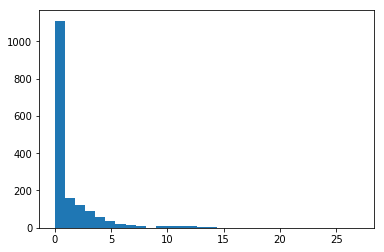

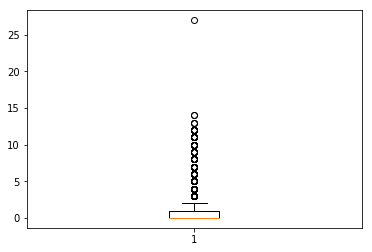

In [22]:
# check FeatureCount for outliers

# histogram
plt.hist(df_museum['FeatureCount'], bins = 30)
plt.show()

# box plot
plt.boxplot(df_museum['FeatureCount'])
plt.show()

In [23]:
# what museum has > 25 feature counts?
df_museum[['MuseumName','FeatureCount']][df_museum['FeatureCount'] > 25]

,MuseumName,FeatureCount
1136,Hagia Sophia Museum / Church (Ayasofya),27


It appears that being featured is uncommon, so any museums that have been featured more than once are outliers in the plot. However removing all of these would remove the data of value from this column. The main outlier is the entry that was featured 27 times, but upon further inspection, it makes sense because this is a very popular museum, and has recently been featured in a popular book series.

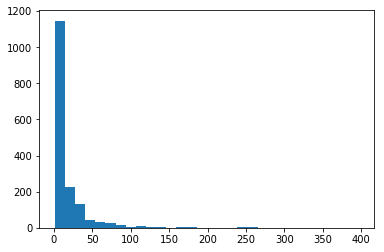

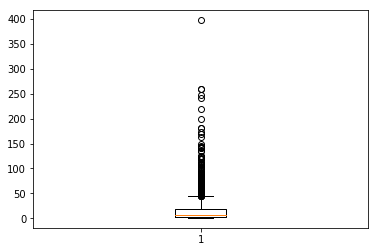

In [24]:
# check Rank for outliers

# histogram
plt.hist(df_museum['Rank'], bins = 30)
plt.show()

# box plot
plt.boxplot(df_museum['Rank'])
plt.show()

In [25]:
# what museum has a ranking > 300?
df_museum[['MuseumName','Rank','TotalThingsToDo','CityUS']][df_museum['Rank'] > 300]

,MuseumName,Rank,TotalThingsToDo,CityUS
188,Museum of Sex,397,1028,New York City


This ranking makes sense given the type of museum and the total number of things to do in this city. I will next plot the Rank on a log scale to evaluate the other outliers.

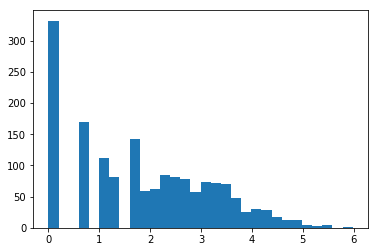

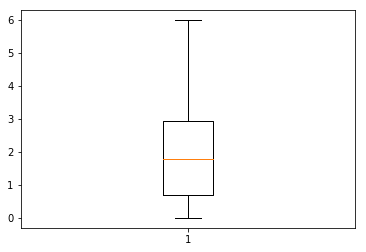

In [26]:
# check Rank on a log scale for outliers

# histogram
plt.hist(np.log(df_museum['Rank']), bins = 30)
plt.show()

# box plot
plt.boxplot(np.log(df_museum['Rank']))
plt.show()

The distribution on a logarithmic scale is reasonable so I won't remove any data from the Rank column.

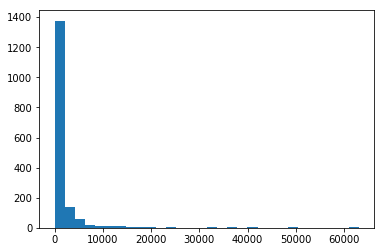

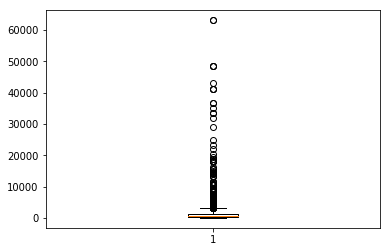

In [27]:
# check ReviewCount for outliers

# histogram
plt.hist(df_museum['ReviewCount'], bins = 30)
plt.show()

# box plot
plt.boxplot(df_museum['ReviewCount'])
plt.show()

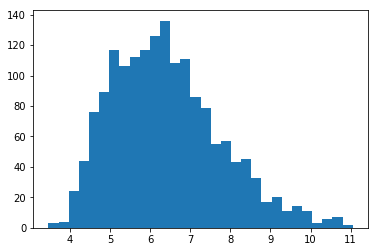

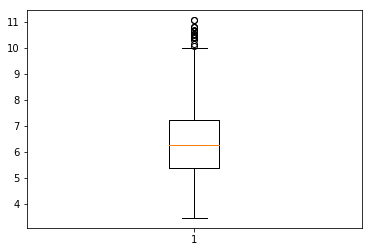

In [28]:
# check ReviewCount for outliers on log scale

# histogram
plt.hist(np.log(df_museum['ReviewCount']), bins = 30)
plt.show()

# box plot
plt.boxplot(np.log(df_museum['ReviewCount']))
plt.show()

In [29]:
# what museums are the remaining outliers - with 30 000+ reviews (log(30000)~=10)?
df_museum[['MuseumName','ReviewCount','Country']][np.log(df_museum['ReviewCount']) > 10]

,MuseumName,ReviewCount,Country
1,The Metropolitan Museum of Art,36627,USA
5,The National 9/11 Memorial & Museum,48437,USA
1014,British Museum,41295,England
1015,Rijksmuseum,25042,The Netherlands
1016,The Metropolitan Museum of Art,36628,USA
1017,Musee d'Orsay,43037,France
1019,Van Gogh Museum,33383,The Netherlands
1024,Prado National Museum,31900,Spain
1027,The National 9/11 Memorial & Museum,48438,USA
1032,Musee du Louvre,63112,France


The log plot of the review counts shows a reasonable distribution. Additionally, all of these museums with very large numbers of reviews make sense, because they are all highly popular worldwide. However, it appears that there are duplicates remaining in the data.

In [30]:
# continue duplicate analysis
print(df_museum[df_museum.duplicated()])

Empty DataFrame
Columns: [Address, Description, FeatureCount, Fee, Longitude, Latitude, LengthOfVisit, MuseumName, PhoneNum, Rank, Rating, ReviewCount, TotalThingsToDo, Country, Continent, SubRegion, CityUS, StateUS]
Index: []


As there are no more fully duplicated rows, I will look for anomalies by inspecting duplicates in the MuseumName column.

In [31]:
# check for duplicates specifically in the MuseumName column
remaining_duplicates = df_museum[df_museum.duplicated(subset='MuseumName',keep=False)].sort_values(by='MuseumName')
remaining_duplicates

,Address,Description,FeatureCount,Fee,Longitude,Latitude,LengthOfVisit,MuseumName,PhoneNum,Rank,Rating,ReviewCount,TotalThingsToDo,Country,Continent,SubRegion,CityUS,StateUS
1021,"Dionysiou Areopagitou 15 | Makriyianni, Athens...","Modern, uptodate building on the foot of the A...",11,Yes,23.73,37.97,2-3 hours,Acropolis Museum,30 210 9000900,1,4.50,18258,324,Greece,Europe,Southern Europe,not in USA,not in USA
1477,"Dionysiou Areopagitou 15 | Makriyianni, Athens...","Modern, uptodate building on the foot of the A...",11,Yes,23.73,37.97,2-3 hours,Acropolis Museum,30 210 9000900,1,4.50,18259,324,Greece,Europe,Southern Europe,not in USA,not in USA
1209,"625 C St, Anchorage, AK 99501-3544","Alaska's largest museum focusing on art, histo...",0,NaN,-149.88,61.22,1-2 hours,Anchorage Museum at Rasmuson Center,907-929-9201,4,4.50,1776,212,USA,Americas,Northern America,Anchorage,AK
97,"625 C St, Anchorage, AK 99501-3544","Alaska's largest museum focusing on art, histo...",0,NaN,-149.88,61.22,1-2 hours,Anchorage Museum at Rasmuson Center,907-929-9201,4,4.50,1775,212,USA,Americas,Northern America,Anchorage,AK
1278,"400 Grand Blvd, Kansas City, MO 64106-1111",The Arabia Steamboat Museum is a favorite Kans...,0,NaN,-94.58,39.11,NaN,Arabia Steamboat Museum,+1 816 471 1856,3,4.50,1331,147,USA,Americas,Northern America,Kansas City,MO
136,"400 Grand Blvd, Kansas City, MO 64106-1111",The Arabia Steamboat Museum is a favorite Kans...,0,NaN,-94.58,39.11,NaN,Arabia Steamboat Museum,+1 816 471 1856,3,4.50,1330,147,USA,Americas,Northern America,Kansas City,MO
4,"111 S Michigan Ave, Chicago, IL 60603-6488","This Classical Renaissance structure, guarded ...",5,Yes,-87.62,41.88,More than 3 hours,Art Institute of Chicago,312 443 3600,1,5.00,15532,614,USA,Americas,Northern America,Chicago,IL
1062,"111 S Michigan Ave, Chicago, IL 60603-6488","This Classical Renaissance structure, guarded ...",5,Yes,-87.62,41.88,More than 3 hours,Art Institute of Chicago,312 443 3600,1,5.00,15533,614,USA,Americas,Northern America,Chicago,IL
1473,"Great Russell Street, London WC1B 3DG, England","A museum of the world, for the world. Discover...",6,No,-0.13,51.52,2-3 hours,British Museum,+44 (0)20 7323 8299,1,4.50,41298,1443,England,Europe,Northern Europe,not in USA,not in USA
1014,"Great Russell Street, London WC1B 3DG, England","A museum of the world, for the world. Discover...",6,No,-0.13,51.52,2-3 hours,British Museum,+44 (0)20 7323 8299,1,4.50,41295,1443,England,Europe,Northern Europe,not in USA,not in USA


Upon inspection of the duplicate data, I see two anomalies:
1. For many duplicate sets, all data is identical except for the ReviewCount which is incremented by ~1-2. My assumption is that the second entry received a few more reviews in the time between when the entries were scraped from the web, so I will keep the entry with the highest review count - which corresponds to the entry with the highest index (though the difference is so minimal it likely wouldn't matter either way).
2. There are several museums that have different addresses/other data, which likely indicates multiple franchise locations. However, the secondary datasets only list MuseumName, and have no address or other information that could be used to map the duplicate entries correctly - e.g. no way to know which traveler types correspond to the Hollywood Wax Museum in LA vs the one in Myrtle Beach (even reviews can't be associated by ReviewCount, because while proportionate, the totals don't match - likely because the data was scraped at different times). Thus, I will have to completely drop these museums from the dataset.

In [32]:
# remove duplicates where only ReviewCount differs (will use MuseumName and Address for simplicity)
df_museum.drop_duplicates(['MuseumName','Address'], keep='last', inplace=True)

# remove all remaining duplicates entirely (i.e. museums with multiple locations)
df_museum.drop_duplicates(['MuseumName'], keep=False, inplace=True)

df_museum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1593 entries, 7 to 1661
Data columns (total 18 columns):
Address            1593 non-null object
Description        1153 non-null object
FeatureCount       1593 non-null int64
Fee                232 non-null object
Longitude          1549 non-null float64
Latitude           1549 non-null float64
LengthOfVisit      563 non-null object
MuseumName         1593 non-null object
PhoneNum           1587 non-null object
Rank               1593 non-null int64
Rating             1593 non-null float64
ReviewCount        1593 non-null int32
TotalThingsToDo    1593 non-null int32
Country            1593 non-null object
Continent          1593 non-null object
SubRegion          1593 non-null object
CityUS             1593 non-null object
StateUS            1593 non-null object
dtypes: float64(3), int32(2), int64(2), object(11)
memory usage: 224.0+ KB


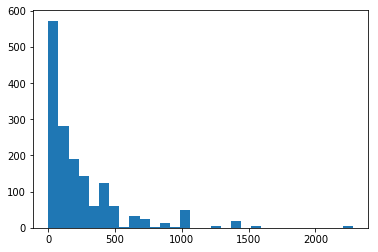

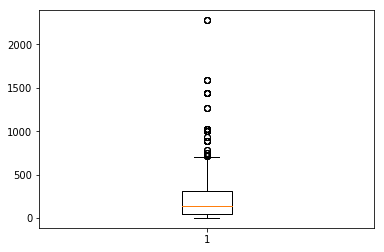

In [33]:
# check TotalThingsToDo for outliers

# histogram
plt.hist(df_museum['TotalThingsToDo'], bins = 30)
plt.show()

# box plot
plt.boxplot(df_museum['TotalThingsToDo'])
plt.show()

In [34]:
# what location has > 2000 things to do?

df_museum[['MuseumName','TotalThingsToDo','Country']][df_museum['TotalThingsToDo'] > 2000]

,MuseumName,TotalThingsToDo,Country
1427,Pushkin State Museum of Fine Arts,2279,Russia
1531,Jewish Museum and Tolerance Center,2279,Russia
1553,Borodino Battle Museum Panorama,2279,Russia
1587,Experimentanium,2279,Russia
1608,The State Central Museum of Contemporary Histo...,2279,Russia


This data point makes sense because Russia is a huge country with many attractions.

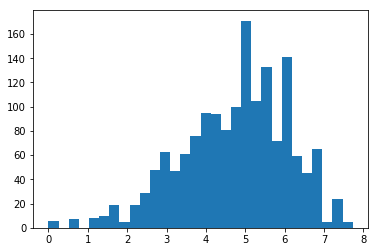

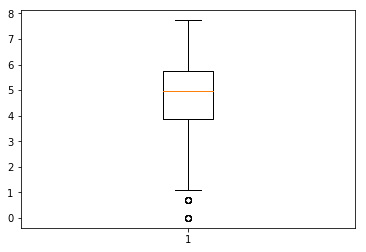

In [35]:
# check TotalThingsToDo for outliers on a log scale

# histogram
plt.hist(np.log(df_museum['TotalThingsToDo']), bins = 30)
plt.show()

# box plot
plt.boxplot(np.log(df_museum['TotalThingsToDo']))
plt.show()

In [36]:
# what locations have < 3 things to do (log(3) ~= 1)?

df_museum[['MuseumName','TotalThingsToDo','Country','Address']][np.log(df_museum['TotalThingsToDo']) < 1]

,MuseumName,TotalThingsToDo,Country,Address
185,Walton's Mountain Museum,2,USA,"Route 617, Schuyler, VA"
591,Loretta Lynn's Ranch,2,USA,"44 Hurricane Mills Rd, Hurricane Mills, TN 370..."
654,Buford Pusser Home and Museum,1,USA,"342 Pusser St, Adamsville, TN 38310-2338"
701,Intel Corp and Museum,2,USA,"2200 Mission College Blvd, Santa Clara, CA 950..."
763,Sky City Cultural Center & Haak'u Museum,1,USA,"Haaku Rd, Pueblo of Acoma, NM 87034"
804,Patton Museum of Cavalry and Armor,2,USA,"Fort Knox, KY"
994,Idaho Potato Museum,1,USA,"130 NW Main St, Blackfoot, ID 83221-2239"
1041,The Tank Museum,1,England,"Bovington, Wareham BH20 6JG, England"
1383,Normandy Tank Museum,1,France,"Avenue du Cotentin | PA La Fourchette, 50500 C..."
1391,December 44 Historical Museum,1,Belgium,"Rue de l'Eglise 7, La Gleize 4987, Belgium"


These data points also make sense because they are in smaller areas/towns that likely wouldn't have many attractions.

#### Traveler ratings data:

In [37]:
# inspect ratings data
print('US traveler ratings')
print(df_ratings_US.columns)
print(df_ratings_US.describe())
print(df_ratings_US.info())
print(df_ratings_US.head())
print('')
print('World traveler ratings')
print(df_ratings_world.columns)
print(df_ratings_world.describe())
print(df_ratings_world.info())
print(df_ratings_world.head())

US traveler ratings
Index(['Gettysburg Heritage Center', 'Hudson River Museum',
       'The Aurora Ice Museum', 'Chrysler Museum of Art', 'Pink Palace Museum',
       'Gettysburg Seminary Ridge Museum', 'Oklahoma Railway Museum',
       'Ships of the Sea Maritime Museum', 'LBJ Presidential Library',
       'Museum Mile',
       ...
       'New England Air Museum',
       'GulfQuest National Maritime Museum of the Gulf of Mexico',
       'Mohave Museum of History and Arts', 'Ellis Island',
       'San Diego Model Railroad Museum', 'Superstition Mountain Museum',
       'Please Touch Museum', 'McClung Museum of Natural History and Culture',
       'NSU Art Museum', 'Morikami Museum & Japanese Gardens'],
      dtype='object', length=1007)
       Gettysburg Heritage Center  Hudson River Museum  The Aurora Ice Museum  \
count                        5.00                 5.00                   5.00   
mean                        49.20                15.20                 107.40   
std        

       Musical Museum  \
count            5.00   
mean            51.60   
std             93.66   
min              0.00   
25%              2.00   
50%              3.00   
75%             36.00   
max            217.00   

       Museum of Natural History (Museum d'Histoire naturelle)  \
count                                               5.00         
mean                                               35.40         
std                                                37.83         
min                                                 2.00         
25%                                                 3.00         
50%                                                24.00         
75%                                                59.00         
max                                                89.00         

       National Football Museum  Escher in Het Paleis (Escher in the Palace)  \
count                      5.00                                         5.00   
mean               

The museum names have been loaded in as the columns, but it would be better to have them as rows instead.

In [38]:
# transpose traveler ratings data
df_ratings_US = df_ratings_US.T
df_ratings_world = df_ratings_world.T

print(df_ratings_US.head())
print(df_ratings_world.head())

                              0    1   2   3   4
Gettysburg Heritage Center  164   63  10   5   4
Hudson River Museum          34   30   9   1   2
The Aurora Ice Museum       242  184  81  16  14
Chrysler Museum of Art      489   94  13   2   1
Pink Palace Museum          183  157  72  10   5
                                                      0    1    2   3   4
Musical Museum                                      217   36    3   0   2
Museum of Natural History (Museum d'Histoire na...   89   59   24   3   2
National Football Museum                            878  594  228  57  33
Escher in Het Paleis (Escher in the Palace)         552  267   33   7   2
Djurgarden                                          767  337   39   3   1


In [39]:
# concatenate dataframes

df_traveler_ratings = pd.concat([df_ratings_US, df_ratings_world]).reset_index()
print(df_traveler_ratings.info())
df_traveler_ratings.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1889 entries, 0 to 1888
Data columns (total 6 columns):
index    1889 non-null object
0        1889 non-null object
1        1889 non-null object
2        1889 non-null object
3        1889 non-null object
4        1889 non-null object
dtypes: object(6)
memory usage: 88.6+ KB
None


,index,0,1,2,3,4
0,Gettysburg Heritage Center,164,63,10,5,4
1,Hudson River Museum,34,30,9,1,2
2,The Aurora Ice Museum,242,184,81,16,14
3,Chrysler Museum of Art,489,94,13,2,1
4,Pink Palace Museum,183,157,72,10,5


In [40]:
# drop duplicate data
df_traveler_ratings.drop_duplicates(keep='first', inplace=True)
print(df_traveler_ratings.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1634 entries, 0 to 1888
Data columns (total 6 columns):
index    1634 non-null object
0        1634 non-null object
1        1634 non-null object
2        1634 non-null object
3        1634 non-null object
4        1634 non-null object
dtypes: object(6)
memory usage: 89.4+ KB
None


In [41]:
# drop duplicate museum names, keeping the last entry (assumed to be the most up-to-date, as per rationale for museum info data)
df_traveler_ratings.drop_duplicates(subset='index', keep='last', inplace=True)
print(df_traveler_ratings.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1603 entries, 0 to 1888
Data columns (total 6 columns):
index    1603 non-null object
0        1603 non-null object
1        1603 non-null object
2        1603 non-null object
3        1603 non-null object
4        1603 non-null object
dtypes: object(6)
memory usage: 87.7+ KB
None


There are now 1603 unique entries, which is more than the museum info data (1593) - this makes sense because 10 museums were removed completely (i.e. ones with multiple locations). These extras will be discarded when I merge the final dataset.

In [42]:
# fix column names (from data source we know the corresponding names)
df_traveler_ratings.columns = ['MuseumName', 'Excellent','Very Good','Average','Poor','Terrible']
df_traveler_ratings.head()

,MuseumName,Excellent,Very Good,Average,Poor,Terrible
0,Gettysburg Heritage Center,164,63,10,5,4
1,Hudson River Museum,34,30,9,1,2
2,The Aurora Ice Museum,242,184,81,16,14
3,Chrysler Museum of Art,489,94,13,2,1
4,Pink Palace Museum,183,157,72,10,5


In [43]:
# fix data types

# mixed data columns, throws weird value error "cannot convert float NaN to integer" on attempt with str.replace(',','').astype(int), so convert fully to strings first
df_traveler_ratings['Excellent'] = df_traveler_ratings['Excellent'].astype('str')
df_traveler_ratings['Very Good'] = df_traveler_ratings['Very Good'].astype('str')
df_traveler_ratings['Average'] = df_traveler_ratings['Average'].astype('str')
df_traveler_ratings['Poor'] = df_traveler_ratings['Poor'].astype('str')
df_traveler_ratings['Terrible'] = df_traveler_ratings['Terrible'].astype('str')

# remove commas and convert all to int
df_traveler_ratings['Excellent'] = df_traveler_ratings['Excellent'].str.replace(',','').astype(int)
df_traveler_ratings['Very Good'] = df_traveler_ratings['Very Good'].str.replace(',','').astype(int)
df_traveler_ratings['Average'] = df_traveler_ratings['Average'].str.replace(',','').astype(int)
df_traveler_ratings['Poor'] = df_traveler_ratings['Poor'].str.replace(',','').astype(int)
df_traveler_ratings['Terrible'] = df_traveler_ratings['Terrible'].str.replace(',','').astype(int)

df_traveler_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1603 entries, 0 to 1888
Data columns (total 6 columns):
MuseumName    1603 non-null object
Excellent     1603 non-null int32
Very Good     1603 non-null int32
Average       1603 non-null int32
Poor          1603 non-null int32
Terrible      1603 non-null int32
dtypes: int32(5), object(1)
memory usage: 56.4+ KB


#### Traveler types data:

In [44]:
# inspect travelers data
print('US traveler types')
print(df_travelers_US.columns)
print(df_travelers_US.describe())
print(df_travelers_US.info())
print(df_travelers_US.head())
print('')
print('World traveler types')
print(df_travelers_world.columns)
print(df_travelers_world.describe())
print(df_travelers_world.info())
print(df_travelers_world.head())

US traveler types
Index(['Gettysburg Heritage Center', 'Hudson River Museum',
       'The Aurora Ice Museum', 'Chrysler Museum of Art', 'Pink Palace Museum',
       'Gettysburg Seminary Ridge Museum', 'Oklahoma Railway Museum',
       'Ships of the Sea Maritime Museum', 'LBJ Presidential Library',
       'Museum Mile',
       ...
       'New England Air Museum',
       'GulfQuest National Maritime Museum of the Gulf of Mexico',
       'Mohave Museum of History and Arts', 'Ellis Island',
       'San Diego Model Railroad Museum', 'Superstition Mountain Museum',
       'Please Touch Museum', 'McClung Museum of Natural History and Culture',
       'NSU Art Museum', 'Morikami Museum & Japanese Gardens'],
      dtype='object', length=1007)
       Gettysburg Heritage Center  Hudson River Museum  The Aurora Ice Museum  \
count                        5.00                 5.00                   5.00   
mean                        45.20                13.60                  96.80   
std          

       Musical Museum  \
count            5.00   
mean            47.00   
std             30.41   
min              4.00   
25%             27.00   
50%             62.00   
75%             65.00   
max             77.00   

       Museum of Natural History (Museum d'Histoire naturelle)  \
count                                               5.00         
mean                                               27.20         
std                                                20.56         
min                                                 6.00         
25%                                                17.00         
50%                                                21.00         
75%                                                32.00         
max                                                60.00         

       National Football Museum  Escher in Het Paleis (Escher in the Palace)  \
count                      5.00                                         5.00   
mean               

In [45]:
# transpose traveler types data (same as for ratings)
df_travelers_US = df_travelers_US.T
df_travelers_world = df_travelers_world.T

print(df_travelers_US.head())
print(df_travelers_US.info())
print(df_travelers_world.head())
print(df_travelers_world.info())

                              0    1   2   3    4
Gettysburg Heritage Center   88   86  17   2   33
Hudson River Museum          25   22   2   4   15
The Aurora Ice Museum       132  204  35   7  106
Chrysler Museum of Art      133  155  52  17   93
Pink Palace Museum          163   84  12   7   41
<class 'pandas.core.frame.DataFrame'>
Index: 1007 entries, Gettysburg Heritage Center to Morikami Museum & Japanese Gardens
Data columns (total 5 columns):
0    1007 non-null object
1    1007 non-null object
2    1007 non-null object
3    1007 non-null object
4    1007 non-null object
dtypes: object(5)
memory usage: 87.2+ KB
None
                                                      0    1    2   3    4
Musical Museum                                       62   65   27   4   77
Museum of Natural History (Museum d'Histoire na...   60   32   17   6   21
National Football Museum                            617  451  178  42  308
Escher in Het Paleis (Escher in the Palace)         145  275  113  3

In [46]:
# concatenate dataframes, drop duplicates and fix column names similar to traveler ratings data

# concatenate dataframes
df_traveler_types = pd.concat([df_travelers_US, df_travelers_world]).reset_index()

# drop duplicate data
df_traveler_types.drop_duplicates(keep='first', inplace=True)

# drop duplicate museums with different entries (keep last, assumed most up-to-date)
df_traveler_types.drop_duplicates(subset='index', keep='last', inplace=True)

# fix column names (from data source we know the corresponding names)
df_traveler_types.columns = ['MuseumName', 'Families','Couples','Solo','Business','Friends']

print(df_traveler_types.info())
df_traveler_types.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1603 entries, 0 to 1888
Data columns (total 6 columns):
MuseumName    1603 non-null object
Families      1603 non-null object
Couples       1603 non-null object
Solo          1603 non-null object
Business      1603 non-null object
Friends       1603 non-null object
dtypes: object(6)
memory usage: 87.7+ KB
None


,MuseumName,Families,Couples,Solo,Business,Friends
0,Gettysburg Heritage Center,88,86,17,2,33
1,Hudson River Museum,25,22,2,4,15
2,The Aurora Ice Museum,132,204,35,7,106
3,Chrysler Museum of Art,133,155,52,17,93
4,Pink Palace Museum,163,84,12,7,41


No missing entries and same number of museums as traveler ratings data, but should be of type int not object.

In [47]:
# fix data types

# mixed data columns, throw value error on attempt with str.replace(',','').astype(int) (because some are already ints), so convert fully to strings first
df_traveler_types['Families'] = df_traveler_types['Families'].astype('str')
df_traveler_types['Couples'] = df_traveler_types['Couples'].astype('str')
df_traveler_types['Solo'] = df_traveler_types['Solo'].astype('str')
df_traveler_types['Business'] = df_traveler_types['Business'].astype('str')
df_traveler_types['Friends'] = df_traveler_types['Friends'].astype('str')

# remove commas and convert all to int
df_traveler_types['Families'] = df_traveler_types['Families'].str.replace(',','').astype(int)
df_traveler_types['Couples'] = df_traveler_types['Couples'].str.replace(',','').astype(int)
df_traveler_types['Solo'] = df_traveler_types['Solo'].str.replace(',','').astype(int)
df_traveler_types['Business'] = df_traveler_types['Business'].str.replace(',','').astype(int)
df_traveler_types['Friends'] = df_traveler_types['Friends'].str.replace(',','').astype(int)

df_traveler_types.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1603 entries, 0 to 1888
Data columns (total 6 columns):
MuseumName    1603 non-null object
Families      1603 non-null int32
Couples       1603 non-null int32
Solo          1603 non-null int32
Business      1603 non-null int32
Friends       1603 non-null int32
dtypes: int32(5), object(1)
memory usage: 56.4+ KB


#### Museum category data:

This one is a bit different because the number of categories varies per museum. So I had to load the data as a dict, and will need to do a conversion and some manipulations to get a nice dataframe.


In [48]:
# convert dict to dataframe
df_categories_US = pd.DataFrame.from_dict(json_category_US, orient = 'index')
df_categories_world = pd.DataFrame.from_dict(json_category_world, orient = 'index')

#inspect museum category data
print('US museum categories')
print(df_categories_US.columns)
print(df_categories_US.describe())
print(df_categories_US.info())
print(df_categories_US.head())
print('')
print('World museum categories')
print(df_categories_world.columns)
print(df_categories_world.describe())
print(df_categories_world.info())
print(df_categories_world.head())

US museum categories
RangeIndex(start=0, stop=9, step=1)
                        0        1        2        3        4        5  \
count                1007     1003      242      128       49       22   
unique                 42       35       31       21       12        6   
top     Specialty Museums  Museums  Museums  Museums  Museums  Museums   
freq                  404      749      132       65       17       10   

              6                   7      8  
count         7                   4      2  
unique        4                   3      2  
top     Museums  Outdoor Activities  Tours  
freq          3                   2      1  
<class 'pandas.core.frame.DataFrame'>
Index: 1007 entries, Gettysburg Heritage Center to Morikami Museum & Japanese Gardens
Data columns (total 9 columns):
0    1007 non-null object
1    1003 non-null object
2    242 non-null object
3    128 non-null object
4    49 non-null object
5    22 non-null object
6    7 non-null object
7    4 non-null ob

In [49]:
# concatenate dataframes

df_categories = pd.concat([df_categories_US, df_categories_world]).reset_index()
print(df_categories.info())
df_categories.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1889 entries, 0 to 1888
Data columns (total 10 columns):
index    1889 non-null object
0        1889 non-null object
1        1883 non-null object
2        448 non-null object
3        239 non-null object
4        91 non-null object
5        48 non-null object
6        14 non-null object
7        6 non-null object
8        2 non-null object
dtypes: object(10)
memory usage: 147.7+ KB
None


,index,0,1,2,3,4,5,6,7,8
0,Gettysburg Heritage Center,History Museums,Museums,None,None,None,None,None,None,None
1,Hudson River Museum,Specialty Museums,Museums,None,None,None,None,None,None,None
2,The Aurora Ice Museum,Specialty Museums,Museums,None,None,None,None,None,None,None
3,Chrysler Museum of Art,Art Museums,Museums,None,None,None,None,None,None,None
4,Pink Palace Museum,History Museums,Natural History Museums,Museums,None,None,None,None,None,None


In [50]:
# drop duplicates
df_categories.drop_duplicates(keep='first', inplace=True)

# drop duplicate museums (keep last for consistency with other data)
df_categories.drop_duplicates(subset='index', keep='last', inplace=True)

df_categories.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1603 entries, 0 to 1888
Data columns (total 10 columns):
index    1603 non-null object
0        1603 non-null object
1        1598 non-null object
2        377 non-null object
3        197 non-null object
4        76 non-null object
5        38 non-null object
6        11 non-null object
7        5 non-null object
8        2 non-null object
dtypes: object(10)
memory usage: 137.8+ KB


Same number of unique museums as traveler ratings and traveler type data.

In [51]:
# restructure data to have museum categories as columns with flags per museum (hacked one hot encoding)

# melt dataframe to lines per museum, category pairs
df_categories = pd.melt(df_categories, id_vars=['index'], value_vars=[0,1,2,3,4,5,6,7,8])

print(df_categories.head())

# pivot counts of museum categories per museum
df_categories = df_categories.pivot_table(index='index', columns='value', aggfunc='count', fill_value=0)

df_categories.head()


                        index variable              value
0  Gettysburg Heritage Center        0    History Museums
1         Hudson River Museum        0  Specialty Museums
2       The Aurora Ice Museum        0  Specialty Museums
3      Chrysler Museum of Art        0        Art Museums
4          Pink Palace Museum        0    History Museums


variable                          \
value                                   Ancient Ruins Architectural Buildings   
index                                                                           
1940 Air Terminal Museum                            0                       0   
21c Museum Hotel                                    0                       0   
21st Century Museum of Contemporary Art             0                       0   
45th Infantry Division Museum                       0                       0   
911 Ground Zero Tour                                0                       0   

                                                                         \
value                                   Arenas & Stadiums Art Galleries   
index                                                                     
1940 Air Terminal Museum                                0             0   
21c Museum Hotel                                        0             0   
21st Century Museum of Contemporary Art                 0             0   
45th Infantry Division Museum                           0             0   
911 Ground Zero Tour                                    0             0   

                                                                              \
value                                   Art Museums Auto Race Tracks Ballets   
index                                                                          
1940 Air Terminal Museum                          0                0       0   
21c Museum Hotel                                  0                0       0   
21st Century Museum of Contemporary Art           1                0       0   
45th Infantry Division Museum                     0                0       0   
911 Ground Zero Tour                              0                0       0   

                                                                    \
value                                   Battlefields Biking Trails   
index                                                                
1940 Air Terminal Museum                           0             0   
21c Museum Hotel                                   0             0   
21st Century Museum of Contemporary Art            0             0   
45th Infantry Division Museum                      0             0   
911 Ground Zero Tour                               0             0   

                                                         ...           \
value                                   Bodies of Water  ... Tramways   
index                                                    ...            
1940 Air Terminal Museum                              0  ...        0   
21c Museum Hotel                                      0  ...        0   
21st Century Museum of Contemporary Art               0  ...        0   
45th Infantry Division Museum                         0  ...        0   
911 Ground Zero Tour                                  0  ...        0   

                                                                           \
value                                   Transportation Traveler Resources   
index                                                                       
1940 Air Terminal Museum                             0                  0   
21c Museum Hotel                                     0                  0   
21st Century Museum of Contemporary Art              0                  0   
45th Infantry Division Museum                        0                  0   
911 Ground Zero Tour                                 0                  0   

                                                                          \
value                                   Valleys Visitor Centers Volcanos   
index                                                                      
1940 Air Terminal Museum                      0               0        0   
21c Museum Hotel                              0               0        0   
21st Centur

In [52]:
# flatten multi-index and reindex
df_categories.columns = df_categories.columns.droplevel(0)
df_categories.reset_index(inplace=True)

# rename museum column
df_categories.rename(columns={'index':'MuseumName'}, inplace=True)

print("Museum Categories")
print(df_categories.columns)

df_categories.head()

Museum Categories
Index(['MuseumName', 'Ancient Ruins', 'Architectural Buildings',
       'Arenas & Stadiums', 'Art Galleries', 'Art Museums', 'Auto Race Tracks',
       'Ballets', 'Battlefields', 'Biking Trails', 'Bodies of Water',
       'Bridges', 'Castles', 'Cemeteries', 'Children's Museums', 'City Tours',
       'Classes & Workshops', 'Coffeehouses', 'Concerts & Shows',
       'Cultural Tours', 'Educational sites', 'Factory Tours',
       'Flea & Street Markets', 'Food & Drink', 'Fun & Games',
       'Game & Entertainment Centers', 'Gardens', 'Geologic Formations',
       'Gift & Specialty Shops', 'Government Buildings', 'Historic Sites',
       'Historic Walking Areas', 'Historical & Heritage Tours',
       'History Museums', 'Islands', 'Lessons & Workshops', 'Libraries',
       'Lighthouses', 'Literary, Art & Music Tours', 'Lookouts',
       'Military Bases & Facilities', 'Military Museums', 'Mines',
       'Monuments & Statues', 'Movie Theaters', 'Museums', 'National Parks',
  

value,MuseumName,Ancient Ruins,Architectural Buildings,Arenas & Stadiums,Art Galleries,Art Museums,Auto Race Tracks,Ballets,Battlefields,Biking Trails,...,Tramways,Transportation,Traveler Resources,Valleys,Visitor Centers,Volcanos,Walking Tours,Wineries & Vineyards,Zipline & Aerial Adventure Parks,Zoos & Aquariums
0,1940 Air Terminal Museum,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,21c Museum Hotel,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,21st Century Museum of Contemporary Art,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,45th Infantry Division Museum,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,911 Ground Zero Tour,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


#### Tag cloud data:

Same process as museum categories

In [53]:
# convert dict to dataframe
df_tags_US = pd.DataFrame.from_dict(json_tags_US, orient = 'index')
df_tags_world = pd.DataFrame.from_dict(json_tags_world, orient = 'index')

#inspect museum category data
print('US tag clouds')
print(df_tags_US.columns)
print(df_tags_US.describe())
print(df_tags_US.info())
print(df_tags_US.head())
print('')
print('World tag clouds')
print(df_tags_world.columns)
print(df_tags_world.describe())
print(df_tags_world.info())
print(df_tags_world.head())

US tag clouds
RangeIndex(start=0, stop=20, step=1)
                          0          1           2           3           4   \
count                    997        997         997         997         997   
unique                   663        697         707         748         773   
top     permanent collection  gift shop  on display  on display  on display   
freq                      40         23          31          23          19   

                5           6           7           8           9   \
count          994         993         991         988         985   
unique         765         778         751         739         712   
top     on display  on display  on display  on display  on display   
freq            24          15          29          21          32   

                10          11          12          13          14  \
count          981         979         977         973         968   
unique         718         658         669         636        

In [54]:
# concatenate dataframes
df_tags = pd.concat([df_tags_US, df_tags_world]).reset_index()

# drop duplicates
df_tags.drop_duplicates(keep='first', inplace=True)

# drop duplicate museums (keep last for consistency with other data)
df_tags.drop_duplicates(subset='index', keep='last', inplace=True)
print(df_tags.info())
print('')

# restructure data to have tags as columns (i.e. hacked one hot encoding)

# melt dataframe to lines per museum, tag pairs
df_tags = pd.melt(df_tags, id_vars=['index'], value_vars=list(range(19)))

# pivot counts of tags per museum
df_tags = df_tags.pivot_table(index='index', columns='value', aggfunc='count', fill_value=0)

# flatten multi-index and reindex
df_tags.columns = df_tags.columns.droplevel(0)
df_tags.reset_index(inplace=True)

# rename museum column
df_tags.rename(columns={'index':'MuseumName'}, inplace=True)

print("Tags")
print(df_tags.columns)

df_tags.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1603 entries, 0 to 1888
Data columns (total 21 columns):
index    1603 non-null object
0        1565 non-null object
1        1565 non-null object
2        1565 non-null object
3        1565 non-null object
4        1565 non-null object
5        1562 non-null object
6        1559 non-null object
7        1556 non-null object
8        1551 non-null object
9        1544 non-null object
10       1539 non-null object
11       1535 non-null object
12       1531 non-null object
13       1523 non-null object
14       1516 non-null object
15       1511 non-null object
16       1504 non-null object
17       1492 non-null object
18       1482 non-null object
19       1472 non-null object
dtypes: object(21)
memory usage: 275.5+ KB
None

Tags
Index(['MuseumName', '2500ft', '3aed', '50rb', '8tl', '91st', '9euros',
       'a bit overpriced', 'a couple times', 'a day in the life',
       ...
       'zimmerman house', 'zip code', 'zip line', 'zombie ou

value,MuseumName,2500ft,3aed,50rb,8tl,91st,9euros,a bit overpriced,a couple times,a day in the life,...,zimmerman house,zip code,zip line,zombie outbreak,zombie tour,zoo,zoo area,zoom,zurich card,zz
0,1940 Air Terminal Museum,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,21c Museum Hotel,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,21st Century Museum of Contemporary Art,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,45th Infantry Division Museum,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,911 Ground Zero Tour,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


There are way too many tags here, so I will inspect further.

value
on display                         772
gift shop                          407
rainy day                          284
all ages                           280
couple of hours                    266
special exhibits                   185
few hours                          167
permanent collection               164
well worth a visit                 164
two hours                          156
free admission                     154
worth a visit                      154
audio guide                        149
exhibits                           139
beautiful building                 131
great collection                   127
interesting exhibits               124
interactive exhibits               116
entrance fee                       115
hands on activities                115
great for kids                     114
information                        109
great exhibits                     107
interactive displays                93
guided tour                         91
great place to visi

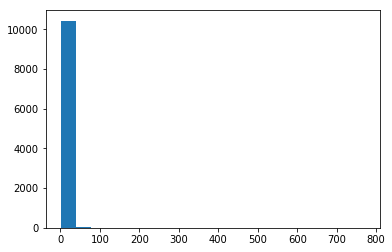

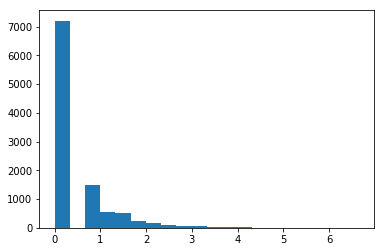

In [55]:
# list tags in descending order
df_tag_counts = df_tags.drop('MuseumName', axis=1).sum().sort_values(ascending=False)
print(df_tag_counts)

# histogram
plt.hist(df_tag_counts, bins = 20)
plt.show()

# histogram, log scale
plt.hist(np.log(df_tag_counts), bins = 20)
plt.show()

The vast majority of tags have very few entries, but a few have many. I will only focus on the top-used tags.

In [56]:
# find tags used at least 50 times
frequent_tags = df_tag_counts[df_tag_counts.values > 30]
frequent_tags

value
on display               772
gift shop                407
rainy day                284
all ages                 280
couple of hours          266
special exhibits         185
few hours                167
permanent collection     164
well worth a visit       164
two hours                156
free admission           154
worth a visit            154
audio guide              149
exhibits                 139
beautiful building       131
great collection         127
interesting exhibits     124
interactive exhibits     116
entrance fee             115
hands on activities      115
great for kids           114
information              109
great exhibits           107
interactive displays      93
guided tour               91
great place to visit      84
his life                  81
traveling exhibits        78
kids and adults           78
local history             77
                        ... 
world war                 38
across the street         37
entry fee                 37
walk aro

In [57]:
frequent_tags_list = list(frequent_tags.index)
df_frequent_tags = df_tags[['MuseumName'] + frequent_tags_list]
df_frequent_tags.head()

value,MuseumName,on display,gift shop,rainy day,all ages,couple of hours,special exhibits,few hours,permanent collection,well worth a visit,...,take pictures,admission,great place to learn,enjoyed our visit,special exhibitions,suggested donation,displays,old west,learn something,life size
0,1940 Air Terminal Museum,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,21c Museum Hotel,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,21st Century Museum of Contemporary Art,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,45th Infantry Division Museum,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,911 Ground Zero Tour,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
df_frequent_tags[df_frequent_tags['MuseumName']=='Gilmore Car Museum']

value,MuseumName,on display,gift shop,rainy day,all ages,couple of hours,special exhibits,few hours,permanent collection,well worth a visit,...,take pictures,admission,great place to learn,enjoyed our visit,special exhibitions,suggested donation,displays,old west,learn something,life size


In [59]:
df_tags[df_tags['MuseumName']=='Gilmore Car Museum']

value,MuseumName,2500ft,3aed,50rb,8tl,91st,9euros,a bit overpriced,a couple times,a day in the life,...,zimmerman house,zip code,zip line,zombie outbreak,zombie tour,zoo,zoo area,zoom,zurich card,zz


### Merge data

In [60]:
# initialize merged dataset with columns of interest from museum info data

df_merged = df_museum[['MuseumName','Address','Continent','SubRegion','Country','CityUS','StateUS','Rating','ReviewCount','FeatureCount','Rank','TotalThingsToDo']].reset_index(drop=True)
df_merged.head()

,MuseumName,Address,Continent,SubRegion,Country,CityUS,StateUS,Rating,ReviewCount,FeatureCount,Rank,TotalThingsToDo
0,The Field Museum,"1400 S Lake Shore Dr, Chicago, IL 60605-2827",Americas,Northern America,USA,Chicago,IL,4.50,5500,4,9,614
1,Smithsonian National Museum of Natural History,"10th Street and Constitution Ave, Washington D...",Americas,Northern America,USA,Washington DC,DC,4.50,7640,7,12,398
2,American Museum of Natural History,"79th Street and Central Park West, New York Ci...",Americas,Northern America,USA,New York City,NY,4.50,13992,11,32,1028
3,National Naval Aviation Museum,"1750 Radford Blvd, NAS Pensacola, Pensacola, F...",Americas,Northern America,USA,Pensacola,FL,5.00,4057,0,1,103
4,National Mississippi River Museum & Aquarium,"350 E 3rd St, Port of Dubuque, Dubuque, IA 520...",Americas,Northern America,USA,Dubuque,IA,4.50,1036,0,2,62


I excluded the following fields because they were either not relevant for further analysis or had too many missing values:
Description, Fee, Longitude, Latitude, LengthOfVisit, PhoneNum

I kept the address field because it contains more granular location information than country for non-US entries

In [61]:
# merge other datasets

# merge traveler ratings data
df_merged = df_merged.merge(df_traveler_ratings, on='MuseumName', how='left')

# check if any didn't merge correctly
df_merged[df_merged.isnull().any(axis=1)]

,MuseumName,Address,Continent,SubRegion,Country,CityUS,StateUS,Rating,ReviewCount,FeatureCount,Rank,TotalThingsToDo,Excellent,Very Good,Average,Poor,Terrible
249,Childrens Museum of Phoenix,"215 N 7th St, Phoenix, AZ 85034-1012",Americas,Northern America,USA,Phoenix,AZ,4.50,483,3,6,218,nan,nan,nan,nan,nan


In [62]:
# inspect ratings data for discrepancy
df_traveler_ratings[df_traveler_ratings['MuseumName'].str.contains('Phoenix')]

,MuseumName,Excellent,Very Good,Average,Poor,Terrible
209,Phoenix Art Museum,374,181,51,11,8
242,Phoenix Police Museum,39,12,1,0,2
559,Children’s Museum of Phoenix,343,94,29,3,3


In [63]:
# fix MuseumName with issue (add curly quote to name)
df_merged.loc[df_merged['MuseumName'] == 'Childrens Museum of Phoenix','MuseumName'] = 'Children’s Museum of Phoenix'

# update values for ratings
df_merged.loc[df_merged['MuseumName'] == 'Children’s Museum of Phoenix','Excellent':'Terrible'] = df_traveler_ratings.loc[df_traveler_ratings['MuseumName'] == 'Children’s Museum of Phoenix','Excellent':'Terrible'].values

In [64]:
# merge traveler types data
df_merged = df_merged.merge(df_traveler_types, on='MuseumName', how='left')

# check if any didn't merge correctly
df_merged[df_merged.isnull().any(axis=1)]

,MuseumName,Address,Continent,SubRegion,Country,CityUS,StateUS,Rating,ReviewCount,FeatureCount,...,Excellent,Very Good,Average,Poor,Terrible,Families,Couples,Solo,Business,Friends


In [65]:
# merge museum category data
df_merged = df_merged.merge(df_categories, on='MuseumName', how='left')

# check if any didn't merge correctly
df_merged[df_merged.isnull().any(axis=1)]

,MuseumName,Address,Continent,SubRegion,Country,CityUS,StateUS,Rating,ReviewCount,FeatureCount,...,Tramways,Transportation,Traveler Resources,Valleys,Visitor Centers,Volcanos,Walking Tours,Wineries & Vineyards,Zipline & Aerial Adventure Parks,Zoos & Aquariums


In [66]:
# merge tag data
df_merged = df_merged.merge(df_frequent_tags, on='MuseumName', how='left')

# check if any didn't merge correctly
df_merged[df_merged.isnull().any(axis=1)]

,MuseumName,Address,Continent,SubRegion,Country,CityUS,StateUS,Rating,ReviewCount,FeatureCount,...,take pictures,admission,great place to learn,enjoyed our visit,special exhibitions,suggested donation,displays,old west,learn something,life size
45,Gilmore Car Museum,"6865 W Hickory Rd, Hickory Corners, MI 49060-9788",Americas,Northern America,USA,Hickory Corners,MI,5.00,367,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
137,Salem Witch Museum,"Washington Square North, Salem, MA 01970",Americas,Northern America,USA,Salem,MA,3.00,1757,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
190,Automobile Driving Museum,"610 Lairport St, El Segundo, CA 90245-5004",Americas,Northern America,USA,El Segundo,CA,4.50,80,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
346,Pontiac-Oakland Automobile Museum,"205 N Mill St, Pontiac, IL 61764-1906",Americas,Northern America,USA,Pontiac,IL,4.50,140,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
366,Children's Discovery Museum,"101 E Beaufort St, Normal, Bloomington-Normal,...",Americas,Northern America,USA,Bloomington-Normal,IL,4.50,104,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
369,IL Route 66 Association Hall of Fame & Museum,"110 W Howard St, Pontiac, IL 61764-1820",Americas,Northern America,USA,Pontiac,IL,4.50,174,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
519,Bruce Museum,"1 Museum Dr, Greenwich, CT 06830-7100",Americas,Northern America,USA,Greenwich,CT,4.50,119,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
611,Tank Museum,"3401 US Hwy 29B, Danville, VA 24540",Americas,Northern America,USA,Danville,VA,4.50,119,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
802,Museum of Clean,"711 S 2nd Ave, Pocatello, ID 83201-6520",Americas,Northern America,USA,Pocatello,ID,4.50,129,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
861,Wisconsin Auto Museum,"147 N Rural St, Hartford, WI 53027-1407",Americas,Northern America,USA,Hartford,WI,4.50,42,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [67]:
# identify museums with missing values
list_missing = list(df_merged.loc[df_merged.isnull().any(axis=1),'MuseumName'])

# inspect entries of missing list in raw data
pd.concat([df_tags_US,df_tags_world]).loc[list_missing]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Gilmore Car Museum,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
Gilmore Car Museum,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
Salem Witch Museum,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
Salem Witch Museum,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
Automobile Driving Museum,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
Automobile Driving Museum,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
Pontiac-Oakland Automobile Museum,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
Children's Discovery Museum,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
IL Route 66 Association Hall of Fame & Museum,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
Bruce Museum,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


None of these museums have any tags, and would have been dropped from the tag data when pivoted. Thus these entries can all be filled with 0 in the merged dataset.

In [68]:
# fill missing tag values with 0
df_merged = df_merged.fillna(0)

### Export clean dataset

In [69]:
df_merged.to_csv('data/museum_data.csv', index=False)